In [1]:
from __future__ import division
from collections import defaultdict
import scipy
import numpy as np
import pickle
import itertools
from dist_rsa.dbm import *
from dist_rsa.utils.load_data import *
from dist_rsa.utils.helperfunctions import *
from dist_rsa.utils.config import abstract_threshold,concrete_threshold
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf

/home/rcohngordon/dist-rsa/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
def visualize(params,line,res,c,q=None):

    cond_probs = np.zeros((len(params.quds), res.size*2))
    for qud_index in range(len(params.quds)):
        subspace_mean,subspace_prior_mean,subspace_variance = params.subspace_means[line][qud_index],params.subspace_prior_means[line][qud_index],params.subspace_variances[line][qud_index]
#         print("prior meannn",subspace_prior_mean)
        vals=scipy.stats.multivariate_normal.pdf((np.arange(-res.size,res.size)*res.amount),mean=subspace_mean,cov=subspace_variance)
        vals/=np.sum(vals)
        cond_probs[qud_index]=vals
        
#         print(scipy.stats.multivariate_normal.pdf([1,2,3],mean=subspace_mean,cov=subspace_variance))
#         print(vals.shape)
#         print(subspace_mean)
#         print("CHECK",np.sum((np.arange(-size,size)*scale+subspace_prior_mean)*vals))

#     print(params.subspace_means.shape)
#     print(params.subspace_means)
#     print("SUBSPACE MEANS",params.subspace_means)
    marginal_mean = np.sum(params.subspace_means[line]*params.qud_marginals)
    print("marginal mean",marginal_mean)
    print("prior mean",subspace_prior_mean)
    marginal = np.sum(cond_probs*np.expand_dims(params.qud_marginals,1),axis=0)
    
    if q is not None:
        print("cond mean",params.subspace_means[line][qud_index])
        print("cond variance",params.subspace_variances[line][qud_index])
        cond = cond_probs[q]
        hm = matplotlib.pyplot.scatter(c=c,x=(np.arange(-res.size,res.size)*res.amount),y=cond)
    
    
#     print("CHECK",np.sum(marginal*(np.arange(-res.size,res.size)*res.amount)))
    else: hm = matplotlib.pyplot.scatter(c=c,x=(np.arange(-res.size,res.size)*res.amount),y=marginal)
#     print("PRIOR MEAN",params.subspace_prior_means[line][0])
    prior_vals = scipy.stats.multivariate_normal.pdf(np.arange(-res.size,res.size)*res.amount,mean=params.subspace_prior_means[line][0],cov=params.l1_sig1)
    prior_vals/=np.sum(prior_vals)
    prior_hm = matplotlib.pyplot.scatter(c='yellow',x=np.arange(-res.size,res.size)*res.amount,y=prior_vals)
    
#     hm_2 = matplotlib.pyplot.scatter(x=(np.arange(-size,size)*scale)+params.subspace_prior_means[line][0],y=marginal)
#     return marginal,marginal_mean,params.subspace_prior_means[line][0]
#     return marginal_means[line]*np.exp(params.qud_marginals)

In [4]:

# vec_size,vec_kind = 25,'glove.twitter.27B.'
vec_size,vec_kind = 300,'glove.6B.'
freqs = pickle.load(open('dist_rsa/data/google_freqs/freqs','rb'))
nouns,adjs = get_words(with_freqs=False)
vecs = load_vecs(mean=True,pca=False,vec_length=vec_size,vec_type=vec_kind) 

def l1_model(subj,pred):

    print('abstract_threshold',abstract_threshold)
    print('concrete_threshold',concrete_threshold)

    qud_words = [a for a in list(adjs) if adjs[a] < abstract_threshold and a in vecs]

    quds = sorted(qud_words,\
#         key=lambda x:scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[pred],vecs[subj]],axis=0)),reverse=False)
        key=lambda x:freqs[x],reverse=True)
    
    quds_near_subj = sorted(qud_words,\
         key=lambda x:scipy.spatial.distance.cosine(vecs[x],vecs[subj]),reverse=False)
    
    quds_near_pred = sorted(qud_words,\
         key=lambda x:scipy.spatial.distance.cosine(vecs[x],vecs[pred]),reverse=False)
    
    quds = quds_near_subj[:100]+quds_near_pred[:100]

    noun_words = [n for n in nouns if nouns[n] > concrete_threshold and n in vecs]
    possible_utterances = sorted(noun_words,\
#         key=lambda x: scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[subj],vecs[subj]],axis=0)),reverse=False)
        key=lambda x:freqs[x],reverse=True)


    for x in possible_utterances:
        if x not in vecs:
            # print(x,"not in vecs")
            possible_utterances.remove(x)
            # raise Exception("utterance not in vecs")

    quds = sorted(list(set(quds[:200])))
    possible_utterances = possible_utterances[:200]

    print("QUDS",quds) 
    print("UTTERANCES:\n",possible_utterances)
#     raise Exception


    params = Inference_Params(
        vecs=vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=list(set(possible_utterances).union(set([pred]))),
        sig1=20.0,sig2=0.1,l1_sig1=20.0,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=True,
        heatmap=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_mixture",
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)


    out = run.tf_results
    tf.reset_default_graph()
    return out,params

    # world_means = run.world_samples
    # print(world_means[:5],"MEANS")

    # print(results[:5])

    # if not is_baseline:
    #     worldm = run.world_movement("cosine",comparanda=[x for x in qud_words if x in vecs])
    #     # print("\nworld\n",worldm[:5])
    # else: worldm = None
        # out.write("\nWORLD MOVEMENT:\n")
        # out.write(str(worldm))
    # print("WORLD MOVEMENT WITH PROJECTION\n:",run.world_movement("cosine",comparanda=[x for x in quds if x in vecs],do_projection=True)[:50])
    # print("BASELINE:\n",sorted(qud_words,\
    #     key=lambda x:scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[subj],vecs[pred]],axis=0)),reverse=False)[:5])

    # demarg = demarginalize_product_space(results)
    # print("\ndemarginalized:\n,",demarg[:5])
    # out.write("\ndemarginalized:\n")
    # out.write((str(demarg)))

    # params.number_of_qud_dimensions=1
    # run = Dist_RSA_Inference(params)
    # run.compute_l1(load=0,save=False)
    # results2 = run.qud_results()
    # # print("\n1d results\n",results2[:10])
    # one_d = results2
    # one_d=None

if __name__ == "__main__":

    

    # for x in range(1):
    #     l1_model(("father","shark",0.5,0.5,1.0,0,100,False))
    results_dict={}
#     for subj,pred in [("woman","rose"),("rose","woman")]:
    for subj,pred in [("athletics","drug")]:
    
        results,params = l1_model(subj=subj,pred=pred)
        results_dict[(subj,pred)]=params

        # print()


        # print(l1_model(subj="man",pred="swimmer"))

        # print(scipy.spatial.distance.cosine(vecs['man']-means1[0],vecs['man']-means2[0]))
        # worlds,quds=l1_model(("wall","frog",1.0,1.0,1.0,0,1000,True))
        # print(quds[:10])






loading vecs (load vecs): glove.6B.mean_vecs300
abstract_threshold 2.5
concrete_threshold 3.0
QUDS ['able', 'academic', 'accredited', 'actual', 'addictive', 'additional', 'advanced', 'adverse', 'alleged', 'amateur', 'annual', 'anti', 'apparent', 'appropriate', 'artistic', 'attempted', 'available', 'aware', 'bad', 'best', 'certain', 'cheap', 'chronic', 'classic', 'classical', 'common', 'competitive', 'complex', 'complicated', 'concerned', 'consecutive', 'contending', 'continental', 'controversial', 'corporate', 'corrupt', 'critical', 'cultural', 'dangerous', 'defunct', 'designated', 'different', 'difficult', 'disappointed', 'disappointing', 'disciplinary', 'easier', 'easy', 'educational', 'effective', 'eligible', 'encouraging', 'entire', 'excellent', 'excited', 'existing', 'experimental', 'extended', 'extensive', 'extracurricular', 'extraordinary', 'fair', 'fake', 'fantastic', 'federal', 'free', 'frequent', 'good', 'governing', 'grand', 'great', 'greater', 'guilty', 'illegal', 'illicit


  0%|          | 0/176 [00:00<?, ?it/s]

subject: ['athletics']
predicate drug
SIGs 1&2: 20.0 0.1
L1 SIG 20.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_mixture RSA with 201 possible utterances and 176
RUNNING DISCRETE MIXTURE MODEL
qud_combinations 176 [['able'], ['academic'], ['accredited'], ['actual'], ['addictive'], ['additional'], ['advanced'], ['adverse'], ['alleged'], ['amateur'], ['annual'], ['anti'], ['apparent'], ['appropriate'], ['artistic'], ['attempted'], ['available'], ['aware'], ['bad'], ['best'], ['certain'], ['cheap'], ['chronic'], ['classic'], ['classical'], ['common'], ['competitive'], ['complex'], ['complicated'], ['concerned'], ['consecutive'], ['contending'], ['continental'], ['controversial'], ['corporate'], ['corrupt'], ['critical'], ['cultural'], ['dangerous'], ['defunct'], ['designated'], ['different'], ['difficult'], ['disappointed'], ['disappointing'], ['disciplinary'], ['easier'], ['easy'], ['educational'], ['effective'], ['eligible'], ['encouraging'], ['entire'], ['excellent'],


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/rcohngordon/dist-rsa/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rcohngordon/dist-rsa/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  1%|          | 1/176 [00:10<31:40, 10.86s/it]

CURRENT QUD: ['academic']


  1%|          | 2/176 [00:20<29:25, 10.15s/it]

CURRENT QUD: ['accredited']


  2%|▏         | 3/176 [00:29<28:47,  9.98s/it]

CURRENT QUD: ['actual']


  2%|▏         | 4/176 [00:39<28:18,  9.88s/it]

CURRENT QUD: ['addictive']


  3%|▎         | 5/176 [00:52<29:51, 10.48s/it]

CURRENT QUD: ['additional']


  3%|▎         | 6/176 [01:02<29:17, 10.34s/it]

CURRENT QUD: ['advanced']


  4%|▍         | 7/176 [01:11<28:52, 10.25s/it]

CURRENT QUD: ['adverse']


  5%|▍         | 8/176 [01:21<28:33, 10.20s/it]

CURRENT QUD: ['alleged']


  5%|▌         | 9/176 [01:33<29:02, 10.44s/it]

CURRENT QUD: ['amateur']


  6%|▌         | 10/176 [01:51<30:44, 11.11s/it]

CURRENT QUD: ['annual']


  6%|▋         | 11/176 [02:01<30:24, 11.06s/it]

CURRENT QUD: ['anti']


  7%|▋         | 12/176 [02:12<30:07, 11.02s/it]

CURRENT QUD: ['apparent']


  7%|▋         | 13/176 [02:23<29:53, 11.00s/it]

CURRENT QUD: ['appropriate']


  8%|▊         | 14/176 [03:10<36:43, 13.60s/it]

CURRENT QUD: ['artistic']


  9%|▊         | 15/176 [03:24<36:37, 13.65s/it]

CURRENT QUD: ['attempted']


  9%|▉         | 16/176 [03:36<36:00, 13.50s/it]

CURRENT QUD: ['available']


 10%|▉         | 17/176 [03:47<35:25, 13.37s/it]

CURRENT QUD: ['aware']


 10%|█         | 18/176 [04:38<40:40, 15.45s/it]

CURRENT QUD: ['bad']


 11%|█         | 19/176 [04:49<39:54, 15.25s/it]

CURRENT QUD: ['best']


 11%|█▏        | 20/176 [05:01<39:08, 15.05s/it]

CURRENT QUD: ['certain']


 12%|█▏        | 21/176 [05:12<38:26, 14.88s/it]

CURRENT QUD: ['cheap']


 12%|█▎        | 22/176 [05:24<37:50, 14.74s/it]

CURRENT QUD: ['chronic']


 13%|█▎        | 23/176 [05:36<37:15, 14.61s/it]

CURRENT QUD: ['classic']


 14%|█▎        | 24/176 [05:47<36:43, 14.50s/it]

CURRENT QUD: ['classical']


 14%|█▍        | 25/176 [06:00<36:14, 14.40s/it]

CURRENT QUD: ['common']


 15%|█▍        | 26/176 [06:12<35:47, 14.32s/it]

CURRENT QUD: ['competitive']


 15%|█▌        | 27/176 [06:45<37:17, 15.02s/it]

CURRENT QUD: ['complex']


 16%|█▌        | 28/176 [06:57<36:49, 14.93s/it]

CURRENT QUD: ['complicated']


 16%|█▋        | 29/176 [07:10<36:23, 14.85s/it]

CURRENT QUD: ['concerned']


 17%|█▋        | 30/176 [07:23<35:59, 14.79s/it]

CURRENT QUD: ['consecutive']


 18%|█▊        | 31/176 [07:36<35:36, 14.74s/it]

CURRENT QUD: ['contending']


 18%|█▊        | 32/176 [07:50<35:15, 14.69s/it]

CURRENT QUD: ['continental']


 19%|█▉        | 33/176 [08:03<34:55, 14.65s/it]

CURRENT QUD: ['controversial']


 19%|█▉        | 34/176 [08:17<34:36, 14.62s/it]

CURRENT QUD: ['corporate']


 20%|█▉        | 35/176 [08:31<34:19, 14.60s/it]

CURRENT QUD: ['corrupt']


 20%|██        | 36/176 [08:45<34:02, 14.59s/it]

CURRENT QUD: ['critical']


 21%|██        | 37/176 [08:59<33:47, 14.58s/it]

CURRENT QUD: ['cultural']


 22%|██▏       | 38/176 [09:14<33:32, 14.58s/it]

CURRENT QUD: ['dangerous']


 22%|██▏       | 39/176 [09:28<33:17, 14.58s/it]

CURRENT QUD: ['defunct']


 23%|██▎       | 40/176 [09:43<33:03, 14.59s/it]

CURRENT QUD: ['designated']


 23%|██▎       | 41/176 [09:58<32:50, 14.60s/it]

CURRENT QUD: ['different']


 24%|██▍       | 42/176 [10:15<32:45, 14.66s/it]

CURRENT QUD: ['difficult']


 24%|██▍       | 43/176 [10:31<32:32, 14.68s/it]

CURRENT QUD: ['disappointed']


 25%|██▌       | 44/176 [10:46<32:19, 14.69s/it]

CURRENT QUD: ['disappointing']


 26%|██▌       | 45/176 [11:02<32:07, 14.71s/it]

CURRENT QUD: ['disciplinary']


 26%|██▌       | 46/176 [11:17<31:55, 14.73s/it]

CURRENT QUD: ['easier']


 27%|██▋       | 47/176 [11:33<31:43, 14.75s/it]

CURRENT QUD: ['easy']


 27%|██▋       | 48/176 [11:49<31:31, 14.78s/it]

CURRENT QUD: ['educational']


 28%|██▊       | 49/176 [12:05<31:20, 14.81s/it]

CURRENT QUD: ['effective']


 28%|██▊       | 50/176 [12:22<31:10, 14.84s/it]

CURRENT QUD: ['eligible']


 29%|██▉       | 51/176 [12:38<30:59, 14.87s/it]

CURRENT QUD: ['encouraging']


 30%|██▉       | 52/176 [12:55<30:48, 14.91s/it]

CURRENT QUD: ['entire']


 30%|███       | 53/176 [13:12<30:38, 14.94s/it]

CURRENT QUD: ['excellent']


 31%|███       | 54/176 [13:29<30:28, 14.98s/it]

CURRENT QUD: ['excited']


 31%|███▏      | 55/176 [13:46<30:18, 15.03s/it]

CURRENT QUD: ['existing']


 32%|███▏      | 56/176 [14:03<30:08, 15.07s/it]

CURRENT QUD: ['experimental']


 32%|███▏      | 57/176 [14:21<29:58, 15.11s/it]

CURRENT QUD: ['extended']


 33%|███▎      | 58/176 [14:39<29:48, 15.16s/it]

CURRENT QUD: ['extensive']


 34%|███▎      | 59/176 [14:57<29:38, 15.20s/it]

CURRENT QUD: ['extracurricular']


 34%|███▍      | 60/176 [15:15<29:29, 15.25s/it]

CURRENT QUD: ['extraordinary']


 35%|███▍      | 61/176 [15:36<29:25, 15.35s/it]

CURRENT QUD: ['fair']


 35%|███▌      | 62/176 [15:54<29:15, 15.40s/it]

CURRENT QUD: ['fake']


 36%|███▌      | 63/176 [16:13<29:05, 15.45s/it]

CURRENT QUD: ['fantastic']


 36%|███▋      | 64/176 [16:32<28:56, 15.50s/it]

CURRENT QUD: ['federal']


 37%|███▋      | 65/176 [16:50<28:46, 15.55s/it]

CURRENT QUD: ['free']


 38%|███▊      | 66/176 [17:09<28:36, 15.60s/it]

CURRENT QUD: ['frequent']


 38%|███▊      | 67/176 [17:29<28:26, 15.66s/it]

CURRENT QUD: ['good']


 39%|███▊      | 68/176 [17:48<28:16, 15.71s/it]

CURRENT QUD: ['governing']


 39%|███▉      | 69/176 [18:08<28:07, 15.77s/it]

CURRENT QUD: ['grand']


 40%|███▉      | 70/176 [18:27<27:57, 15.83s/it]

CURRENT QUD: ['great']


 40%|████      | 71/176 [18:47<27:47, 15.88s/it]

CURRENT QUD: ['greater']


 41%|████      | 72/176 [19:08<27:38, 15.94s/it]

CURRENT QUD: ['guilty']


 41%|████▏     | 73/176 [19:28<27:28, 16.01s/it]

CURRENT QUD: ['illegal']


 42%|████▏     | 74/176 [19:48<27:18, 16.07s/it]

CURRENT QUD: ['illicit']


 43%|████▎     | 75/176 [20:09<27:09, 16.13s/it]

CURRENT QUD: ['immune']


 43%|████▎     | 76/176 [20:30<26:59, 16.20s/it]

CURRENT QUD: ['important']


 44%|████▍     | 77/176 [20:52<26:50, 16.27s/it]

CURRENT QUD: ['impressive']


 44%|████▍     | 78/176 [21:14<26:40, 16.34s/it]

CURRENT QUD: ['inaugural']


 45%|████▍     | 79/176 [21:35<26:31, 16.40s/it]

CURRENT QUD: ['independent']


 45%|████▌     | 80/176 [21:57<26:21, 16.47s/it]

CURRENT QUD: ['infamous']


 46%|████▌     | 81/176 [22:19<26:11, 16.54s/it]

CURRENT QUD: ['intense']


 47%|████▋     | 82/176 [22:42<26:01, 16.61s/it]

CURRENT QUD: ['interested']


 47%|████▋     | 83/176 [23:04<25:51, 16.68s/it]

CURRENT QUD: ['interscholastic']


 48%|████▊     | 84/176 [23:27<25:41, 16.75s/it]

CURRENT QUD: ['intramural']


 48%|████▊     | 85/176 [23:53<25:34, 16.87s/it]

CURRENT QUD: ['keen']


 49%|████▉     | 86/176 [24:16<25:24, 16.94s/it]

CURRENT QUD: ['latest']


 49%|████▉     | 87/176 [24:39<25:13, 17.01s/it]

CURRENT QUD: ['legal']


 50%|█████     | 88/176 [25:03<25:03, 17.08s/it]

CURRENT QUD: ['legendary']


 51%|█████     | 89/176 [25:27<24:53, 17.17s/it]

CURRENT QUD: ['likely']


 51%|█████     | 90/176 [25:52<24:43, 17.25s/it]

CURRENT QUD: ['limited']


 52%|█████▏    | 91/176 [26:16<24:32, 17.33s/it]

CURRENT QUD: ['longtime']


 52%|█████▏    | 92/176 [26:41<24:22, 17.41s/it]

CURRENT QUD: ['lucrative']


 53%|█████▎    | 93/176 [27:06<24:11, 17.49s/it]

CURRENT QUD: ['main']


 53%|█████▎    | 94/176 [27:31<24:01, 17.57s/it]

CURRENT QUD: ['major']


 54%|█████▍    | 95/176 [27:57<23:50, 17.66s/it]

CURRENT QUD: ['martial']


 55%|█████▍    | 96/176 [28:22<23:39, 17.74s/it]

CURRENT QUD: ['mental']


 55%|█████▌    | 97/176 [28:48<23:27, 17.82s/it]

CURRENT QUD: ['modern']


 56%|█████▌    | 98/176 [29:14<23:16, 17.90s/it]

CURRENT QUD: ['municipal']


 56%|█████▋    | 99/176 [29:40<23:05, 17.99s/it]

CURRENT QUD: ['national']


 57%|█████▋    | 100/176 [30:07<22:53, 18.07s/it]

CURRENT QUD: ['necessary']


 57%|█████▋    | 101/176 [30:33<22:41, 18.15s/it]

CURRENT QUD: ['negative']


 58%|█████▊    | 102/176 [31:00<22:29, 18.24s/it]

CURRENT QUD: ['notable']


 59%|█████▊    | 103/176 [31:27<22:17, 18.32s/it]

CURRENT QUD: ['notorious']


 59%|█████▉    | 104/176 [31:54<22:05, 18.41s/it]

CURRENT QUD: ['ongoing']


 60%|█████▉    | 105/176 [32:21<21:53, 18.49s/it]

CURRENT QUD: ['other']


 60%|██████    | 106/176 [32:49<21:40, 18.58s/it]

CURRENT QUD: ['outstanding']


 61%|██████    | 107/176 [33:17<21:28, 18.67s/it]

CURRENT QUD: ['overall']


 61%|██████▏   | 108/176 [33:46<21:15, 18.76s/it]

CURRENT QUD: ['particular']


 62%|██████▏   | 109/176 [34:14<21:03, 18.85s/it]

CURRENT QUD: ['pending']


 62%|██████▎   | 110/176 [34:43<20:50, 18.94s/it]

CURRENT QUD: ['perfect']


 63%|██████▎   | 111/176 [35:12<20:36, 19.03s/it]

CURRENT QUD: ['personal']


 64%|██████▎   | 112/176 [35:40<20:23, 19.12s/it]

CURRENT QUD: ['pleased']


 64%|██████▍   | 113/176 [36:10<20:09, 19.21s/it]

CURRENT QUD: ['political']


 65%|██████▍   | 114/176 [36:44<19:58, 19.33s/it]

CURRENT QUD: ['popular']


 65%|██████▌   | 115/176 [37:13<19:44, 19.42s/it]

CURRENT QUD: ['positive']


 66%|██████▌   | 116/176 [37:43<19:30, 19.51s/it]

CURRENT QUD: ['possible']


 66%|██████▋   | 117/176 [38:13<19:16, 19.60s/it]

CURRENT QUD: ['potent']


 67%|██████▋   | 118/176 [38:43<19:01, 19.69s/it]

CURRENT QUD: ['potential']


 68%|██████▊   | 119/176 [39:13<18:47, 19.78s/it]

CURRENT QUD: ['powerful']


 68%|██████▊   | 120/176 [39:43<18:32, 19.86s/it]

CURRENT QUD: ['preliminary']


 69%|██████▉   | 121/176 [40:14<18:17, 19.95s/it]

CURRENT QUD: ['prestigious']


 69%|██████▉   | 122/176 [40:45<18:02, 20.04s/it]

CURRENT QUD: ['preventive']


 70%|██████▉   | 123/176 [41:15<17:46, 20.13s/it]

CURRENT QUD: ['prior']


 70%|███████   | 124/176 [41:46<17:31, 20.21s/it]

CURRENT QUD: ['professional']


 71%|███████   | 125/176 [42:17<17:15, 20.30s/it]

CURRENT QUD: ['promising']


 72%|███████▏  | 126/176 [42:48<16:59, 20.38s/it]

CURRENT QUD: ['proud']


 72%|███████▏  | 127/176 [43:19<16:42, 20.47s/it]

CURRENT QUD: ['rampant']


 73%|███████▎  | 128/176 [43:50<16:26, 20.55s/it]

CURRENT QUD: ['ready']


 73%|███████▎  | 129/176 [44:22<16:10, 20.64s/it]

CURRENT QUD: ['regular']


 74%|███████▍  | 130/176 [44:54<15:53, 20.73s/it]

CURRENT QUD: ['regulatory']


 74%|███████▍  | 131/176 [45:26<15:36, 20.81s/it]

CURRENT QUD: ['reigning']


 75%|███████▌  | 132/176 [45:58<15:19, 20.90s/it]

CURRENT QUD: ['renowned']


 76%|███████▌  | 133/176 [46:30<15:02, 20.98s/it]

CURRENT QUD: ['reputed']


 76%|███████▌  | 134/176 [47:02<14:44, 21.07s/it]

CURRENT QUD: ['respective']


 77%|███████▋  | 135/176 [47:35<14:27, 21.15s/it]

CURRENT QUD: ['responsible']


 77%|███████▋  | 136/176 [48:08<14:09, 21.24s/it]

CURRENT QUD: ['satisfied']


 78%|███████▊  | 137/176 [48:40<13:51, 21.32s/it]

CURRENT QUD: ['secondary']


 78%|███████▊  | 138/176 [49:13<13:33, 21.40s/it]

CURRENT QUD: ['serious']


 79%|███████▉  | 139/176 [49:46<13:15, 21.49s/it]

CURRENT QUD: ['severe']


 80%|███████▉  | 140/176 [50:20<12:56, 21.57s/it]

CURRENT QUD: ['significant']


 80%|████████  | 141/176 [50:53<12:37, 21.66s/it]

CURRENT QUD: ['similar']


 81%|████████  | 142/176 [51:27<12:19, 21.74s/it]

CURRENT QUD: ['social']


 81%|████████▏ | 143/176 [52:01<12:00, 21.83s/it]

CURRENT QUD: ['sophisticated']


 82%|████████▏ | 144/176 [52:34<11:41, 21.91s/it]

CURRENT QUD: ['special']


 82%|████████▏ | 145/176 [53:08<11:21, 21.99s/it]

CURRENT QUD: ['specific']


 83%|████████▎ | 146/176 [53:42<11:02, 22.07s/it]

CURRENT QUD: ['storied']


 84%|████████▎ | 147/176 [54:17<10:42, 22.16s/it]

CURRENT QUD: ['subsequent']


 84%|████████▍ | 148/176 [54:52<10:22, 22.24s/it]

CURRENT QUD: ['successful']


 85%|████████▍ | 149/176 [55:26<10:02, 22.33s/it]

CURRENT QUD: ['super']


 85%|████████▌ | 150/176 [56:01<09:42, 22.41s/it]

CURRENT QUD: ['supposed']


 86%|████████▌ | 151/176 [56:42<09:23, 22.53s/it]

CURRENT QUD: ['sure']


 86%|████████▋ | 152/176 [57:17<09:02, 22.61s/it]

CURRENT QUD: ['surprising']


 87%|████████▋ | 153/176 [57:52<08:41, 22.69s/it]

CURRENT QUD: ['talented']


 88%|████████▊ | 154/176 [58:27<08:21, 22.78s/it]

CURRENT QUD: ['technical']


 88%|████████▊ | 155/176 [59:02<07:59, 22.86s/it]

CURRENT QUD: ['therapeutic']


 89%|████████▊ | 156/176 [59:38<07:38, 22.94s/it]

CURRENT QUD: ['true']


 89%|████████▉ | 157/176 [1:00:22<07:18, 23.07s/it]

CURRENT QUD: ['typical']


 90%|████████▉ | 158/176 [1:00:58<06:56, 23.16s/it]

CURRENT QUD: ['unable']


 90%|█████████ | 159/176 [1:01:34<06:34, 23.23s/it]

CURRENT QUD: ['unaware']


 91%|█████████ | 160/176 [1:02:09<06:12, 23.31s/it]

CURRENT QUD: ['unbeaten']


 91%|█████████▏| 161/176 [1:02:45<05:50, 23.39s/it]

CURRENT QUD: ['unclear']


 92%|█████████▏| 162/176 [1:03:20<05:28, 23.46s/it]

CURRENT QUD: ['undefeated']


 93%|█████████▎| 163/176 [1:03:56<05:05, 23.54s/it]

CURRENT QUD: ['undercover']


 93%|█████████▎| 164/176 [1:04:32<04:43, 23.61s/it]

CURRENT QUD: ['unlikely']


 94%|█████████▍| 165/176 [1:05:12<04:20, 23.71s/it]

CURRENT QUD: ['unrelated']


 94%|█████████▍| 166/176 [1:05:48<03:57, 23.78s/it]

CURRENT QUD: ['upcoming']


 95%|█████████▍| 167/176 [1:06:24<03:34, 23.86s/it]

CURRENT QUD: ['urgent']


 95%|█████████▌| 168/176 [1:07:00<03:11, 23.93s/it]

CURRENT QUD: ['various']


 96%|█████████▌| 169/176 [1:07:36<02:48, 24.00s/it]

CURRENT QUD: ['vice']


 97%|█████████▋| 170/176 [1:08:13<02:24, 24.08s/it]

CURRENT QUD: ['victorious']


 97%|█████████▋| 171/176 [1:08:50<02:00, 24.15s/it]

CURRENT QUD: ['widespread']


 98%|█████████▊| 172/176 [1:09:26<01:36, 24.22s/it]

CURRENT QUD: ['willing']


 98%|█████████▊| 173/176 [1:10:03<01:12, 24.30s/it]

CURRENT QUD: ['worried']


 99%|█████████▉| 174/176 [1:10:40<00:48, 24.37s/it]

CURRENT QUD: ['worse']


 99%|█████████▉| 175/176 [1:11:17<00:24, 24.44s/it]

CURRENT QUD: ['wrong']


100%|██████████| 176/176 [1:11:54<00:00, 24.52s/it]


time: 4314.7946853637695
time: 136.85492730140686
time: 90.68949031829834


In [7]:
class Results_Pickler:
    def __init__(self,path,results_dict=None):
        self.path=path
        self.results_dict=results_dict
        
    def save(self):    
        for t in self.results_dict:
            pickle.dump(Pickleable_Params(self.results_dict[t]),open(self.path+t[0]+t[1],'wb'))
        
    def retrieve(self,t):
        return pickle.load(open(self.path+t[0]+t[1],'rb'))


class Pickleable_Params:
    def __init__(self,d):
        self.quds=d.quds
        self.qud_marginals=d.qud_marginals
        self.subspace_prior_means=d.subspace_prior_means
        self.subspace_means=d.subspace_means
        self.subspace_variances=d.subspace_variances
        self.l1_sig1=d.l1_sig1


# r = Results_Pickler(results_dict=results_dict,path="dist_rsa/data/results/pickles/version8aug")
# r.save()
  


In [8]:
r = Results_Pickler(path="dist_rsa/data/results/pickles/version8aug")

r.path

'dist_rsa/data/results/pickles/version8aug'

In [15]:
ps = results_dict[('athletics','drug')]
ps.subspace_means.shape
len(list(set(ps.quds)))
# len(ps.possible_utterances)

181

RESOLUTION. SIZE: 50 AMOUNT: 0.2
[('anti', 0.15462781), ('notorious', 0.15448633), ('reputed', 0.15232348), ('illicit', 0.14823292), ('illegal', 0.1456678), ('addictive', 0.14246722), ('undercover', 0.049794454), ('rampant', 0.013514529), ('preventive', 0.005445719), ('potent', 0.0032270728), ('therapeutic', 0.0028283074), ('fantastic', 0.002733437), ('adverse', 0.0012815271), ('excited', 0.0009721417), ('fake', 0.00058365427), ('great', 0.00057069096), ('excellent', 0.0005312935), ('classical', 0.00052203593), ('alleged', 0.0005024662), ('perfect', 0.000477063), ('secondary', 0.00042821112), ('corrupt', 0.0003994047), ('impressive', 0.00038713997), ('effective', 0.00033584016), ('grand', 0.00033361313), ('artistic', 0.00033261688), ('chronic', 0.00033213), ('immune', 0.00033170456), ('modern', 0.00031336228), ('infamous', 0.00029672167), ('extended', 0.00023948724), ('lucrative', 0.0002315106), ('continental', 0.00020693029), ('notable', 0.00020351086), ('dangerous', 0.00020254431), (

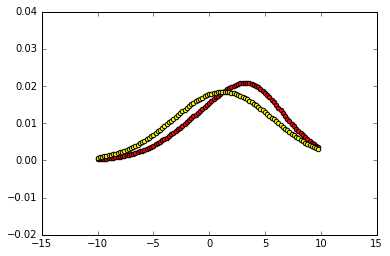

In [13]:
# ps = params
ps = results_dict[('athletics','drug')]
# ps = results_dict[('woman','rose')]
# ps = r.retrieve(('athletics','drug'))
res = Resolution(10.0,50)
# res = ps.resolution
# qud = sorted(ps.quds).index("effective")
# _,_,_ = visualize(ps,qud,res,'red')
# print("QUD:",ps.quds[qud])
print(sorted(list(zip(sorted(ps.quds),ps.qud_marginals)),key=lambda x:x[1],reverse=True))

# for i in range(len(ps.quds)):
#     if i > 0: _,_,_ = visualize(params,i,res,'red')

qud = sorted(ps.quds).index("anti")
print("QUD",sorted(ps.quds)[qud])
visualize(ps,qud,res,'red')

#PRIOR
# vals = scipy.stats.multivariate_normal.pdf(np.arange(-res.size,res.size)*res.amount,mean=params.subspace_prior_means[line][0],cov=5.0)
# hm = matplotlib.pyplot.scatter(c='yellow',x=np.arange(-res.size,res.size)*res.amount,y=vals)


In [10]:
from __future__ import division
from collections import defaultdict
import scipy
import numpy as np
import pickle
import itertools
from dist_rsa.dbm import *
from dist_rsa.utils.load_data import *
from dist_rsa.utils.helperfunctions import *
from dist_rsa.utils.config import abstract_threshold,concrete_threshold
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from dist_rsa.utils.simple_vecs import real_vecs as simple_vecs
import itertools
from dist_rsa.dbm import Resolution




def l1_model(subj,pred,sig1,sig2,l1_sig1,quds,possible_utterances):
    vec_size,vec_kind = 25,'glove.twitter.27B.'

    vecs = simple_vecs
    real_vecs= simple_vecs

    print("UTTERANCES:\n",sorted(list(set(possible_utterances).union(set([pred]))))[:20])

    params = Inference_Params(
        vecs=real_vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=sorted(list(set(possible_utterances).union(set([pred])))),
        sig1=sig1,sig2=sig2, l1_sig1=l1_sig1,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_mixture",
        heatmap=True,
        calculate_projected_marginal_world_posterior=True,
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)
    tf_results = run.tf_results
    return tf_results,params

if __name__ == "__main__":

    results,params = l1_model(subj="child",pred="shark",sig1=5.0,sig2=0.5,l1_sig1=5.0,quds=["vicious","swims"],possible_utterances=["shark","swimmer","man"])


UTTERANCES:
 ['man', 'shark', 'swimmer']
RESOLUTION. SIZE: 100 AMOUNT: 0.1
subject: ['child']
predicate shark
SIGs 1&2: 5.0 0.5
L1 SIG 5.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_mixture RSA with 3 possible utterances and 2
RUNNING DISCRETE MIXTURE MODEL
qud_combinations 2 [['swims'], ['vicious']]
quds 2
SIZE,AMOUNT 100 0.1


  0%|          | 0/2 [00:00<?, ?it/s]

CURRENT QUD: ['swims']


 50%|█████     | 1/2 [00:02<00:02,  2.88s/it]

CURRENT QUD: ['vicious']


100%|██████████| 2/2 [00:05<00:00,  2.92s/it]


COVARIANCES [[5.        1.4298646]
 [5.        1.697474 ]]
time: 7.0724101066589355
time: 1.2253165245056152
HEATMAP MEAN [-0.30686018  1.6534688 ]
subspace_vector [[0.]
 [1.]] orthogonal_basis_np [[-1.  0.]
 [ 0.  1.]] line in orthogonal_basis [[0.]
 [1.]] qud index 0 var [[1.4298646]] cov at qud [5.        1.4298646]
subspace_vector [[0.]
 [1.]] orthogonal_basis_np [[0. 1.]
 [1. 0.]] line in orthogonal_basis [[1.]
 [0.]] qud index 1 var [[5.]] cov at qud [5.       1.697474]
subspace_vector [[1.]
 [0.]] orthogonal_basis_np [[-1.  0.]
 [ 0.  1.]] line in orthogonal_basis [[-1.]
 [ 0.]] qud index 0 var [[5.]] cov at qud [5.        1.4298646]
subspace_vector [[1.]
 [0.]] orthogonal_basis_np [[0. 1.]
 [1. 0.]] line in orthogonal_basis [[0.]
 [1.]] qud index 1 var [[1.697474]] cov at qud [5.       1.697474]
time: 18.862341165542603


x 1.6534686896460529
y -0.30685639061348846


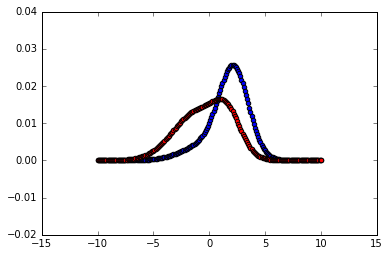

In [14]:
# hm_vals = np.flip(np.flip(params.heatmaps[1],axis=0),axis=1)
# print(params.means)
# print(params.qud_marginals)
# print(params.means*np.expand_dims(params.qud_marginals,1))
# worlds = params.heatmaps[1]

# print(np.array_equal(hms,params.heatmaps))
# print(params.qud_marginals)
# raise Exception

# print(results[1])
# print(params.qud_marginals)
# raise Exception


# transposed_hms = np.asarray([np.flip(params.heatmaps[0].T,axis=0),np.flip(params.heatmaps[1].T,axis=1)])
# transposed_hms = np.asarray([params.heatmaps[0],params.heatmaps[1]])
# worlds = np.sum(transposed_hms*np.reshape(params.qud_marginals,(2,1,1)),axis=0)
# worlds = params_heatmaps[0]

# worlds = np.flip(params.heatmaps[0].T,axis=0)
# worlds = np.flip(params.heatmaps[1].T,axis=1)

# print(worlds)
worlds = params.worlds
# raise Exception
hm = matplotlib.pyplot.scatter(c='blue',x=(np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount),y=np.sum(worlds,axis=0))
hm = matplotlib.pyplot.scatter(c='red',x=(np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount),y=np.sum(worlds,axis=1))

x = np.sum(worlds,axis=0)
print("x",np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*x))

y = np.sum(worlds,axis=1)
print("y",np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*y))


marginal mean -0.307034904178618
prior mean -1.0
marginal mean 1.6534728437245823
prior mean 0.1


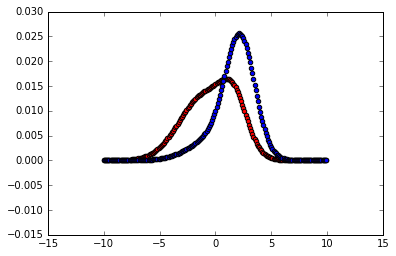

In [15]:
# res = Resolution(5,100)
res = params.resolution
# res.amount=1
# why is yellow and blue the same
# a = visualize(params,1,res,'blue',q=0)
# a = visualize(params,1,res,'red',q=1)
# a = visualize(params,1,res,'yellow',q=None)
# a = visualize(params,0,res,'green',q=None)
a = visualize(params,0,res,'red',q=None)
a = visualize(params,1,res,'blue',q=None)
# visualize(params,1,res,'red',q=1)
# visualize(params,1,res,'blue',q=0)
# visualize(params,1,res,'blue',q=1)
# _,_,_ = visualize(params,1,res,'blue')



#PRIOR
# vals = scipy.stats.multivariate_normal.pdf(np.arange(-res.size,res.size)*res.amount,mean=params.subspace_prior_means[0][0],cov=5.0)
# hm = matplotlib.pyplot.scatter(c='yellow',x=np.arange(-res.size,res.size)*res.amount,y=vals)


In [8]:
from __future__ import division
from collections import defaultdict
import scipy
import numpy as np
import pickle
import itertools
from dist_rsa.dbm import *
from dist_rsa.utils.load_data import *
from dist_rsa.utils.helperfunctions import *
from dist_rsa.utils.config import abstract_threshold,concrete_threshold
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from dist_rsa.utils.simple_vecs import real_vecs as simple_vecs
import itertools
from dist_rsa.dbm import Resolution




def l1_model(subj,pred,sig1,sig2,l1_sig1,quds,possible_utterances):
    vec_size,vec_kind = 25,'glove.twitter.27B.'

    vecs = simple_vecs
    real_vecs= simple_vecs

    print("UTTERANCES:\n",sorted(list(set(possible_utterances).union(set([pred]))))[:20])

    params = Inference_Params(
        vecs=real_vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=sorted(list(set(possible_utterances).union(set([pred])))),
        sig1=sig1,sig2=sig2, l1_sig1=l1_sig1,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_exact",
        heatmap=True
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)
    tf_results = run.tf_results
    return tf_results,params

if __name__ == "__main__":

    results,params = l1_model(subj="man",pred="swimmer",sig1=5.0,sig2=0.5,l1_sig1=5.0,quds=["vicious","swims"],possible_utterances=["shark","swimmer","man"])


UTTERANCES:
 ['man', 'shark', 'swimmer']
RESOLUTION. SIZE: 100 AMOUNT: 0.1
subject: ['man']
predicate swimmer
SIGs 1&2: 5.0 0.5
L1 SIG 5.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_exact RSA with 3 possible utterances and 2
RUNNING DISCRETE EXACT MODEL
QUDS: [['swims'], ['vicious']]
sum should be unit 0.9999997
MEAN [-0.7909157   0.81742287]


-0.7908981402030009
-0.8174242649214138


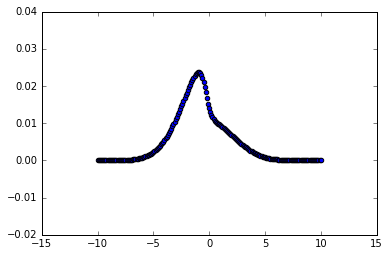

In [10]:
hm_vals = results[0]
# *np.expand_dims(params.qud_marginals,1)
# y=np.sum(hm_vals,axis=1)
# x=(np.arange(-params.resolution.size,params.resolution.size)*params.resolution.amount)
# print(x.shape,y.shape)
hm = matplotlib.pyplot.scatter(c='blue',x=(np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount),y=np.sum(hm_vals,axis=0))
# print((hm_vals))
y = np.sum(hm_vals,axis=1)
print(np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*y))
x = np.sum(hm_vals,axis=0)
print(np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*x))